## Linear Discriminant Analysis (LDA)

### Imports

In [1]:
#-------------Imports--------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Also import LDA from sklearn to test our version against it
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### Load dataset

In [3]:
#-----------Load Dataset-----------

path_train = "fashion_train.npy"
path_test = "fashion_test.npy"

train = np.load(path_train)
test = np.load(path_test)

#Split the training and test data into features and labels
X_train = train[:,:784]
y_train = train[:,784]

X_test = test[:,:784]
y_test = test[:,784]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10000, 784)
(10000,)
(5000, 784)
(5000,)


## Compute Within Class Scatter Matrix

Compute using the formula

$$S_W = \sum_{i=1}^{c} S_i$$

Where:<br>
$c$ = number of classes

Where $S_i$ is the scatter matrix for every class:

$$S_i = \sum_{x \in D_i}^{n} (x - m_i){(x - m_i)^T}$$

Where:<br>
$n$ = number of rows in class<br>
$m_i$ = mean vector of class i<br>

$m_i$ is the mean vector containing all the means of the features in class i

$$m_i = \frac{1}{n_i}\sum_{x \in D_i}^{n} x_k$$

Where:<br>
$n_i$ = number of rows in class i<br>
$x_k$ = feature<br>

In [4]:
#--------------Compute Within Class Scatter Matrix---------------
def get_Sw(X, y):
    
    N = X.shape[1] #number of features
    S_w = np.zeros((N,N))
    class_labels = np.unique(y)
    c = class_labels.shape[0] #number of classes

    #calculate scatter matrix for each class
    for class_ in range(c):

        S_i = np.zeros((N,N))
        class_subset = X[y == class_] #get rows which are a part of the current class
        mean_vector = (np.mean(class_subset, axis=0)).reshape(N, 1) #vector m_i containing
        #means of all features in class i
        
        for row_idx in range(class_subset.shape[0]):
    
            x = (class_subset[row_idx, :]).reshape(N, 1)
            S_i += (np.dot((x - mean_vector), np.transpose(x - mean_vector))) #apply formula for within class scatter matrix
        
        S_w += S_i
        
    return S_w

## Compute Between Class Scatter Matrix

Compute using the formula

$$S_B = \sum_{i=1}^{c} N_i(m_i - m){(m_i - m)}^T$$

Where:<br>
$c$ = number of classes<br>
$m$ = overall mean<br>
$m_i$ = mean vector of class i<br>
(Where $m_i$ follows the same formula as the one described above for the $S_W$)

In [6]:
#--------------Compute Between Class Scatter Matrix---------------
def get_Sb(X, y):
    
    N = X.shape[1] #number of features
    m = (np.mean(X, axis=0)).reshape(N,1) #overall mean
    S_b = np.zeros((N,N))
    class_labels = np.unique(y)
    c = class_labels.shape[0] #number of classes
    
    for class_ in range(c):
        
        class_subset = X[y == class_]
        n_rows = class_subset.shape[0] #get number of rows which are a part of the current class
        mean_vector = (np.mean(class_subset, axis=0)).reshape(N, 1) #vector m_i containing
        #means of all features in class i
        S_b += n_rows * ((mean_vector - m).dot((mean_vector - m).T)) #apply formula for between class scatter matrix
        
    return S_b

## Calculate eigenvectors and eigenvalues

For the matrix ${S_W}^{-1}S_B$ to obtain the linear discriminants<br>
Return them sorted by the eigenvalues in decreasing order to easily be able to select the top $k$ (in our case 2) eigenvectors that explain the most variance of our data

In [11]:
def get_linear_discriminants(S_w, S_b):
    
    # calculate the eigenvectors and eigenvalues of the matrix ((S_w)^-1)(S_b)
    eig_vals, eig_vecs = np.linalg.eig((np.linalg.inv(S_w)).dot(S_b))
    
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))] #create a list of corresponding
    #eigenvectors and eigenvalues
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    #sort the list by the eigenvalues in decreasing order
    
    return eig_pairs

Print variance explained by the first $k$ linear discriminants

In [12]:
def variance_explained(eig_pairs, eig_vals, k=10):
    
    eigv_sum = np.sum(eig_vals)
    count = 0
    for i,j in enumerate(eig_pairs):
        if count >= k:
            break
        print(f"eigenvalue {i+1}: {(j[0]/eigv_sum).real}")
        count += 1

## Plot projection onto first 2 linear discriminants

Transform samples onto the new subspace using the formula

$$Y = X \times W$$

Where:<br>
$Y$ = Transformed samples in the new subspace<br>
$X$ = Samples<br>
$W$ = $N \times 2$ dimensional matrix formed by the first 2 linear discriminants<br><br>

Then plot this transformed data using a scatter plot to visualize the data projected onto the first 2 linear discriminants<br>
Note:<br>
Our plot function is heavily inspired by the plot function in the tutorial at https://sebastianraschka.com/Articles/2014_python_lda.html<br>

In [18]:
def run_LDA(X, y):
    
    N = X.shape[1] #get number of features
    S_w = get_Sw(X_train, y_train) #get within class scatter matrix
    S_b = get_Sb(X_train, y_train) #get between class scatter matrix
    
    sorted_eigenvecs = get_linear_discriminants(S_w, S_b) #get linear discriminants sorted by
    #variance explained in descending order (most descriptive first)
    
    #get first 2 linear discriminants
    W = np.hstack((sorted_eigenvecs[0][1].reshape(N,1), sorted_eigenvecs[1][1].reshape(N,1)))
    
    #transform the samples onto the new subspace
    transformed = X.dot(W)
    
    plot_LDA(transformed, y_train)

In [20]:
def plot_LDA(transformed, y_train):
    
    '''Plot the data projected onto the first 2 linear discriminants'''
    
    #Note: Plot function heavily inspired by the one in the tutorial at 
    #https://sebastianraschka.com/Articles/2014_python_lda.html to make
    #the plot look nice
    
    #map class labels to their actual meaning
    label_dict = {0: "t-shirt/top", 1: "trousers", 2: "pullover", 3: "dress", 4: "shirt"}
    
    for label,color in zip(
        range(5),('blue', 'red', 'green', 'purple', 'orange')):

        plt.scatter(x=transformed[:,0].real[y_train == label],
                y=transformed[:,1].real[y_train == label],
                color=color,
                alpha=0.5,
                label=label_dict[label])
    
    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('Projection onto the first 2 linear discriminants')
    
    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    plt.show()
        

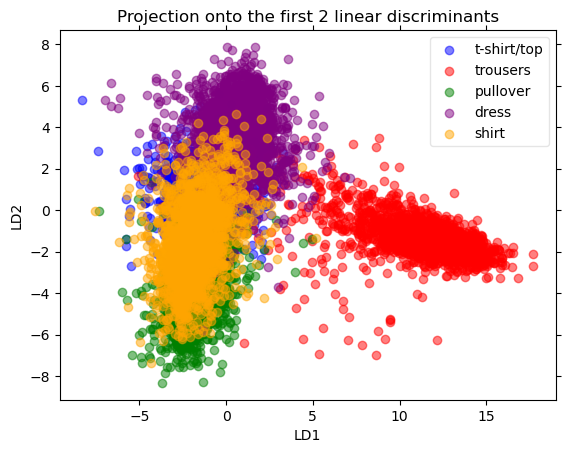

In [19]:
run_LDA(X_train, y_train)

## Comparison with LDA from sklearn

We compared our implementation of LDA with the one from sklearn, making a similar plot, to validate our results.<br>
Again, the plot function, very similar to the one above, was heavily inspired by the one in the tutorial at https://sebastianraschka.com/Articles/2014_python_lda.html

In [24]:
def plot_sklearn_LDA(transformed, y_train):
    
    label_dict = {0: "t-shirt/top", 1: "trousers", 2: "pullover", 3: "dress", 4: "shirt"}
    
    for label,color in zip(
        range(5),('blue', 'red', 'green', 'purple', 'orange')):

        plt.scatter(x=transformed[:,0][y_train == label],
                    y=transformed[:,1][y_train == label] * -1, # flip the figure
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title("Sklearn LDA")

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    plt.show()


In [21]:
clf = LDA(n_components=2)
lda_scikit = clf.fit_transform(X_train, y_train)

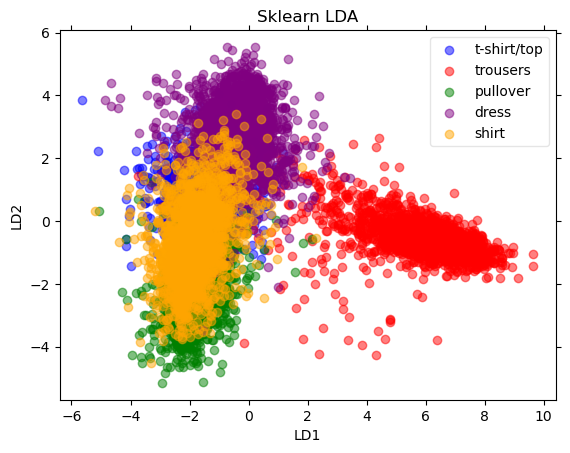

In [25]:
plot_sklearn_LDA(lda_scikit, y_train)